In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 远程 Zarr 数据链接（CHIRPS 全集）
store_url = "https://nyu1.osn.mghpcc.org/leap-pangeo-pipeline/chirps_feedstock/chirps-global-daily.zarr"
# 加载 Zarr 数据（lazy loading）
ds = xr.open_dataset(store_url, engine="zarr", consolidated=True)

# 自动判断纬度顺序并裁剪 Ghana 区域（4°N–11°N, -3°–2°E）
lat_min, lat_max = 4, 11
if ds.latitude[0] < ds.latitude[-1]:
    lat_slice = slice(lat_min, lat_max)
else:
    lat_slice = slice(lat_max, lat_min)

ghana_ds = ds.sel(
    latitude=lat_slice,
    longitude=slice(-3, 2),
    time=slice("2000-01-01", "2020-12-31")
)

# 保存为 NetCDF 文件
ghana_ds.to_netcdf("ghana_chirps_2000_2020.nc")

In [2]:
print(ghana_ds)

<xarray.Dataset> Size: 430MB
Dimensions:    (latitude: 140, longitude: 100, time: 7671)
Coordinates:
  * latitude   (latitude) float32 560B 4.025 4.075 4.125 ... 10.87 10.92 10.97
  * longitude  (longitude) float32 400B -2.975 -2.925 -2.875 ... 1.925 1.975
  * time       (time) datetime64[ns] 61kB 2000-01-01 2000-01-02 ... 2020-12-31
Data variables:
    precip     (time, latitude, longitude) float32 430MB ...
Attributes: (12/16)
    Conventions:                   CF-1.6
    acknowledgements:              The Climate Hazards Group InfraRed Precipi...
    creator_email:                 pete@geog.ucsb.edu
    creator_name:                  Pete Peterson
    documentation:                 http://pubs.usgs.gov/ds/832/
    faq:                           http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ
    ...                            ...
    pangeo_forge_build_timestamp:  2024-11-19T21:19:44.192735+00:00
    pangeo_forge_gh_actions_url:   https://github.com/leap-stc/chirps_feedsto...
    refe

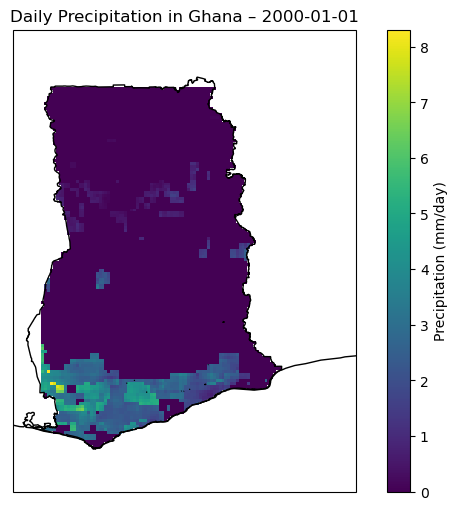

In [3]:
# 导入所需库
import xarray as xr
import geopandas as gpd
import rioxarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# 第一步：读取降水数据 (裁剪过的 nc 文件)
ds = xr.open_dataset("ghana_chirps_2000_2020.nc")
ds = ds.rio.write_crs("EPSG:4326")  # 确保坐标系设置好

# 第二步：读取 Ghana 边界 shapefile
ghana_shape = gpd.read_file("gadm41_GHA_shp/gadm41_GHA_0.shp")  # 改成你文件夹下的 Level 0 路径

# 第三步：裁剪 NetCDF 数据到 Ghana 边界
ghana_clipped = ds.rio.clip(ghana_shape.geometry, ghana_shape.crs, drop=True)

# 第四步：绘图（以第1天为例，即 2000-01-01）
plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ghana_clipped['precip'].isel(time=0).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    cbar_kwargs={'label': 'Precipitation (mm/day)'}
)
ghana_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=1)  # 加上 Ghana 边界线
ax.set_title("Daily Precipitation in Ghana – 2000-01-01")
ax.set_extent([-3.5, 2.5, 4, 12], crs=ccrs.PlateCarree())  # 控制地图边框
ax.coastlines()
plt.show()

In [4]:
ghana_clipped['precip'].isel(time=0).values  # 查看具体值
ghana_clipped['precip'].isel(time=0).isnull().sum().values  # 统计 NaN 数量

array(2753)

In [5]:
### Graph 1 ###

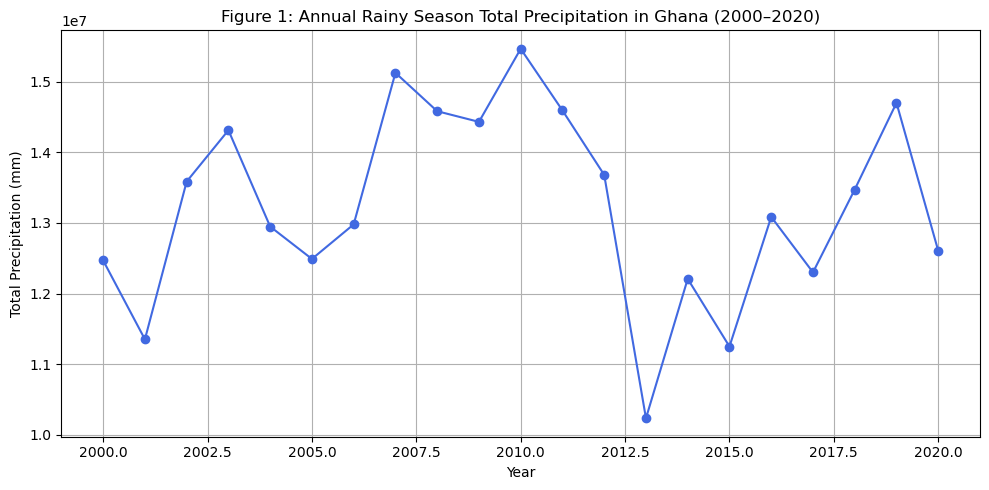

In [12]:
ds = xr.open_dataset('ghana_chirps_2000_2020.nc')
precip = ds['precip']
years = np.arange(2000, 2021)

# Compute Annual Rainy Season Total Precipitation (March–June assumed pre-filtered)
annual_total = precip.groupby('time.year').sum(dim=['time', 'latitude', 'longitude'])

# Plot Figure: Annual Rainy Season Total Precipitation
plt.figure(figsize=(10, 5))
plt.plot(years, annual_total.values, marker='o', linestyle='-', color='royalblue')
plt.title("Figure 1: Annual Rainy Season Total Precipitation in Ghana (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Total Precipitation (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

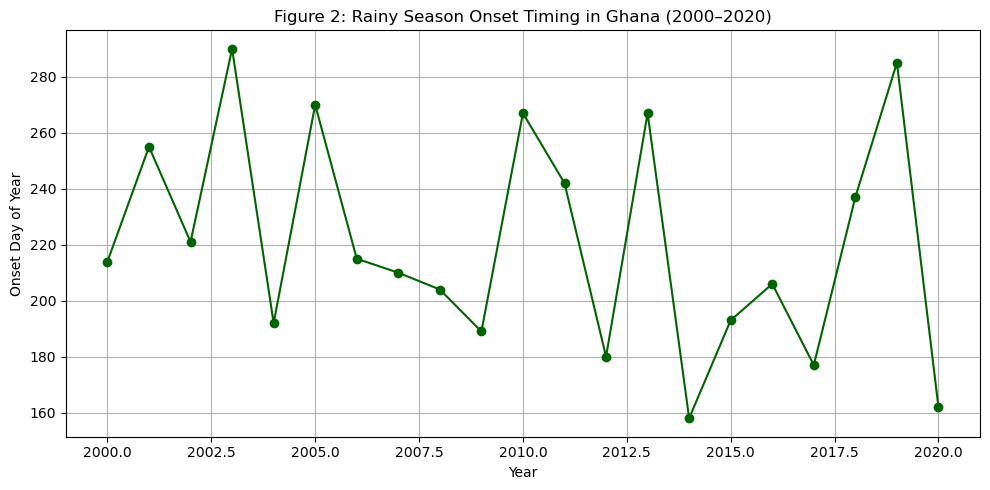

In [13]:
rolling = precip.rolling(time=5).mean()
onset_days = []
for year in years:
    season = rolling.sel(time=str(year))
    mean_over_space = season.mean(dim=['latitude', 'longitude'])
    onset_day = mean_over_space.where(mean_over_space > 1).argmax(dim='time')
    onset_days.append(ds.time.sel(time=str(year))[onset_day].dt.dayofyear.values)

# Plot Figure 1: Rainy Season Onset Timing (Day of Year)
plt.figure(figsize=(10, 5))
plt.plot(years, onset_days, marker='o', linestyle='-', color='darkgreen')
plt.title("Figure 2: Rainy Season Onset Timing in Ghana (2000–2020)")
plt.xlabel("Year")
plt.ylabel("Onset Day of Year")
plt.grid(True)
plt.tight_layout()
plt.show()

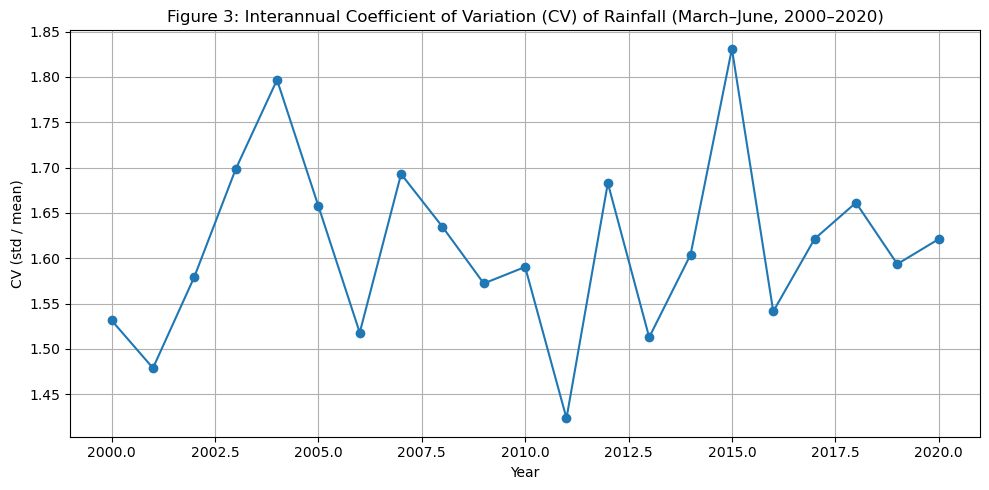

In [14]:
precip = precip.sel(time=precip['time'].dt.month.isin([3, 4, 5, 6]))

# Group by year and compute mean and std over time and space
season_mean = precip.groupby('time.year').mean(dim=['time', 'latitude', 'longitude'])
season_std = precip.groupby('time.year').std(dim=['time', 'latitude', 'longitude'])

# Calculate Coefficient of Variation (CV)
cv = season_std / season_mean

# Plot CV time series
plt.figure(figsize=(10, 5))
cv.plot(marker='o')
plt.title("Figure 3: Interannual Coefficient of Variation (CV) of Rainfall (March–June, 2000–2020)")
plt.xlabel("Year")
plt.ylabel("CV (std / mean)")
plt.grid(True)
plt.tight_layout()
plt.show()

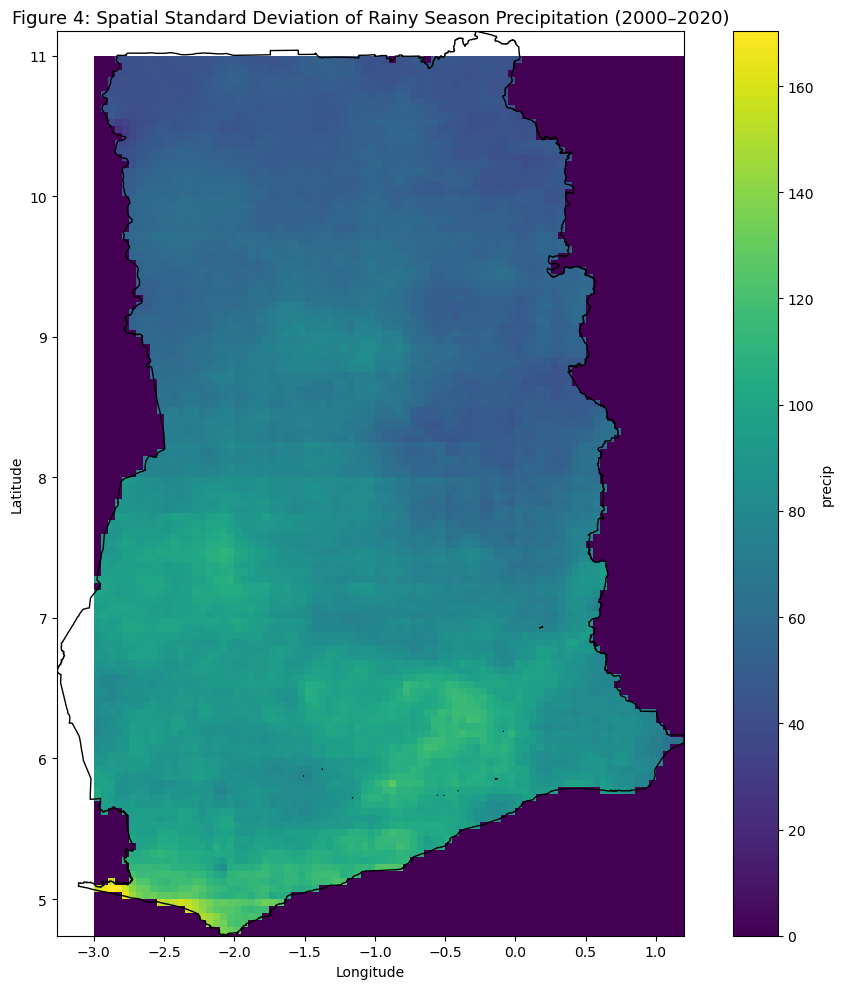

In [20]:
import regionmask

ghana_shp = gpd.read_file("gadm41_GHA_shp/gadm41_GHA_0.shp")

fig, ax = plt.subplots(figsize=(10, 10))

# 绘制空间标准差图
spatial_std_map.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'precip'})

# 叠加边界线（你已有的 gpd 数据）
ghana_shp.boundary.plot(ax=ax, edgecolor='black', linewidth=1)

# 设置坐标轴和标题
ax.set_title("Figure 4: Spatial Standard Deviation of Rainy Season Precipitation (2000–2020)", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(ghana_shp.total_bounds[[0, 2]])
ax.set_ylim(ghana_shp.total_bounds[[1, 3]])
ax.set_aspect('equal')  # 统一经纬度比例
plt.tight_layout()
plt.show()

In [49]:
# 计算每个像素点在2000–2020年间的降水标准差
std_map = ghana_clipped['precip'].std(dim='time')

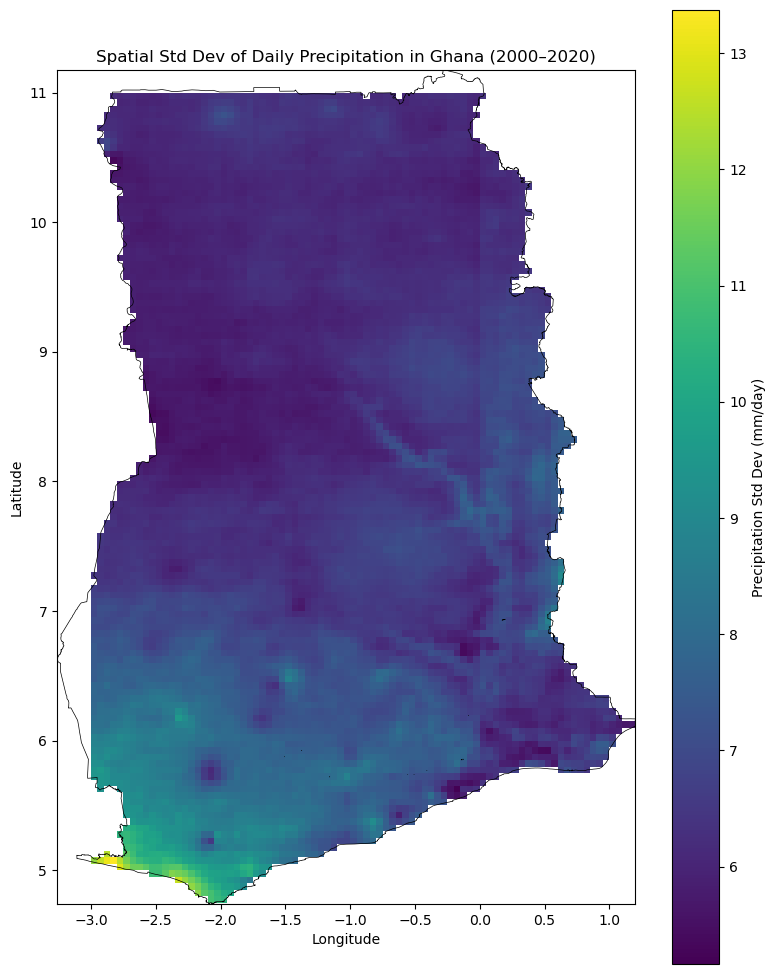

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

# 创建 axes 对象
ax = plt.gca()

# 绘制标准差图
std_map.plot(
    ax=ax,
    cmap='viridis',
    cbar_kwargs={'label': 'Precipitation Std Dev (mm/day)'}
)

# 添加边界
ghana_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)

# 设置标题、坐标轴
ax.set_title("Spatial Std Dev of Daily Precipitation in Ghana (2000–2020)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# ✅ 设置等比比例
ax.set_aspect('equal')  # 强制经纬度单位比例一致
ax.set_xlim(ghana_shape.total_bounds[[0, 2]])
ax.set_ylim(ghana_shape.total_bounds[[1, 3]])

plt.tight_layout()
plt.show()


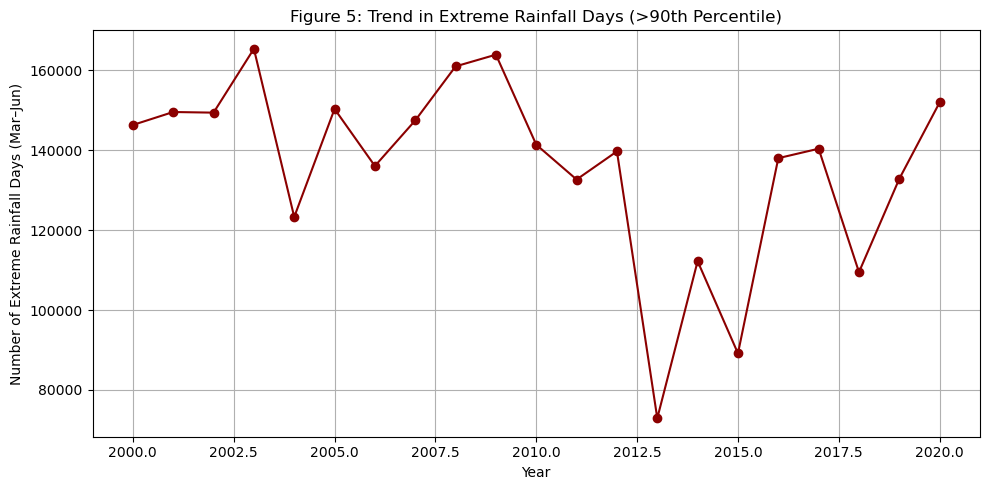

In [24]:
q90 = precip.quantile(0.9, dim='time')

# Step 2: 判断每个像素在每一天是否极端
extreme_mask = precip > q90

# Step 3: 每年统计极端降水日的天数（按时间分组后，对空间求和）
extreme_days = extreme_mask.groupby('time.year').sum(dim=['time', 'latitude', 'longitude'])

# Step 4: 提取年份和对应的极端日数
years = extreme_days['year'].values
counts = extreme_days.values

# Step 5: 绘图
plt.figure(figsize=(10, 5))
plt.plot(years, counts, marker='o', linestyle='-', color='darkred')
plt.title("Figure 5: Trend in Extreme Rainfall Days (>90th Percentile)")
plt.xlabel("Year")
plt.ylabel("Number of Extreme Rainfall Days (Mar–Jun)")
plt.grid(True)
plt.tight_layout()
plt.show()